# Trabalho 03 - Modelo Generativo - VAE
#### Caio Bonani Carvalho
#### Enzo Reis de Oliveira

## Dataset Wine

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_digits
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


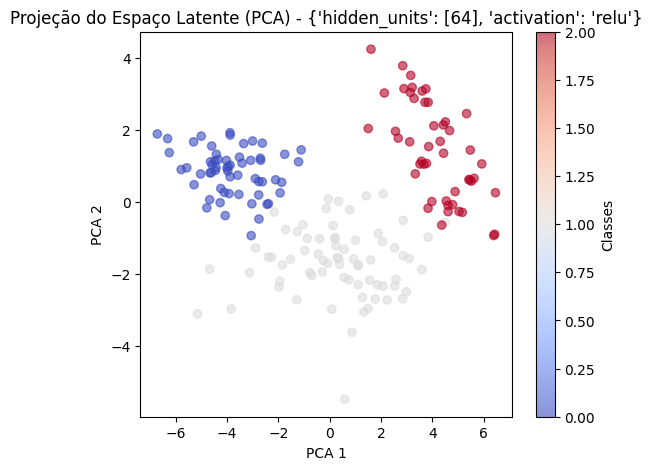

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


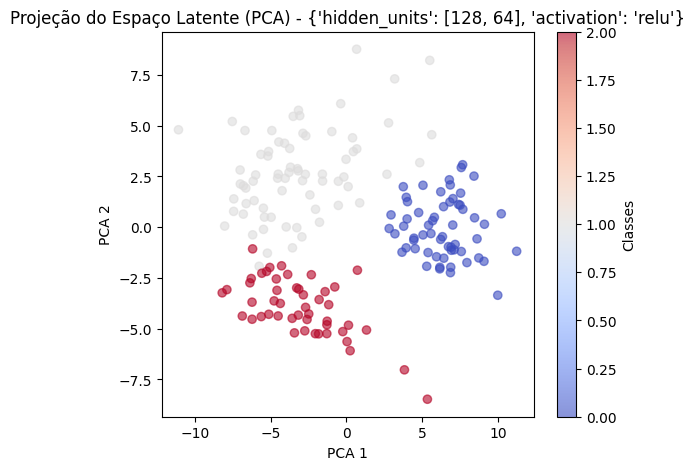

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


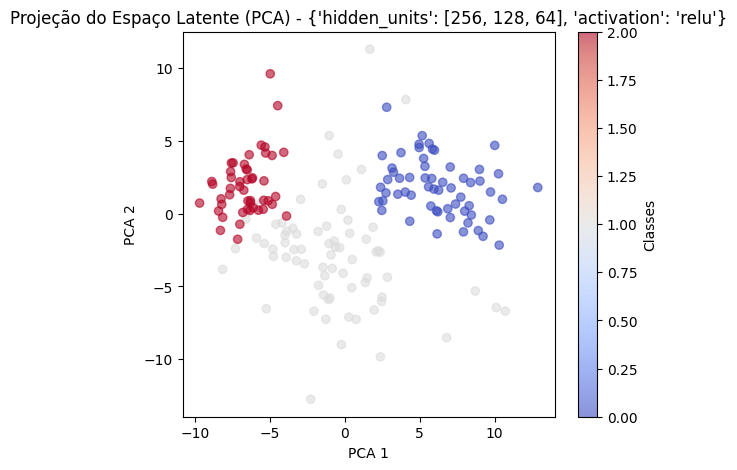

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


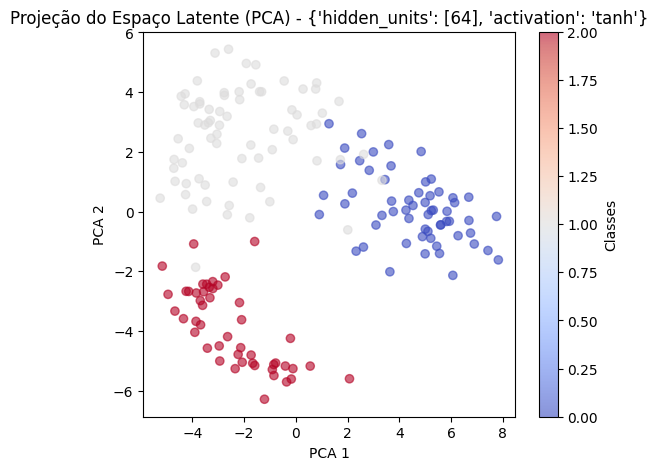

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


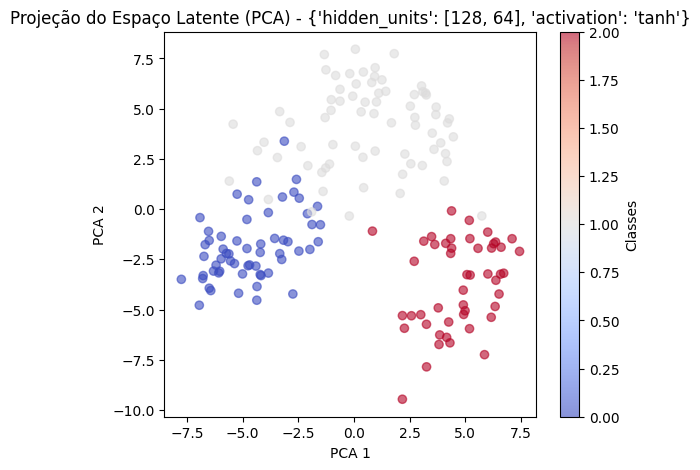

                                        Architecture  Final Loss  \
0       {'hidden_units': [64], 'activation': 'relu'}    0.411298   
1  {'hidden_units': [128, 64], 'activation': 'relu'}    0.330962   
2  {'hidden_units': [256, 128, 64], 'activation':...    0.252632   
3       {'hidden_units': [64], 'activation': 'tanh'}    0.449637   
4  {'hidden_units': [128, 64], 'activation': 'tanh'}    0.399900   

   Explained Variance (PCA)  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  


In [16]:
wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2

architectures = [
    {"hidden_units": [64], "activation": "relu"},
    {"hidden_units": [128, 64], "activation": "relu"},
    {"hidden_units": [256, 128, 64], "activation": "relu"},
    {"hidden_units": [64], "activation": "tanh"},
    {"hidden_units": [128, 64], "activation": "tanh"},
]

results = []

for arch in architectures:
    inputs = keras.Input(shape=(input_dim,))
    h = inputs
    for units in arch["hidden_units"]:
        h = layers.Dense(units, activation=arch["activation"])(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = latent_inputs
    for units in reversed(arch["hidden_units"]):
        h = layers.Dense(units, activation=arch["activation"])(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - {arch}")
    plt.show()

    results.append({
        "Architecture": str(arch),
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)


Os resultados das projeções no espaço latente indicam que todas as arquiteturas conseguiram separar bem as classes no PCA, com algumas variações na dispersão e compactação dos clusters. A tabela final mostra as perdas finais dos modelos, o que nos dá uma ideia da eficiência de cada configuração.
	•	Melhor Arquitetura em termos de Loss: { 'hidden_units': [256, 128, 64], 'activation': 'relu' }, com loss final de 0.2563.
	•	Melhor Separação Visual: A arquitetura { 'hidden_units': [128, 64], 'activation': 'relu' } parece oferecer uma boa separação entre as classes, com menos sobreposição.

Os modelos com ReLU tendem a ter separação mais nítida, enquanto Tanh produziu projeções mais suavizadas, mas com um leve aumento na perda.

2. Análise da Variância Explicada

A explicação de variância do PCA foi 1.0 para todas as arquiteturas, o que sugere que os primeiros dois componentes principais conseguiram capturar toda a variância relevante do espaço latente. Isso significa que o espaço latente de 2D projetado pelo PCA representa bem a informação extraída pelo VAE.


## Utilizando diferentes Loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


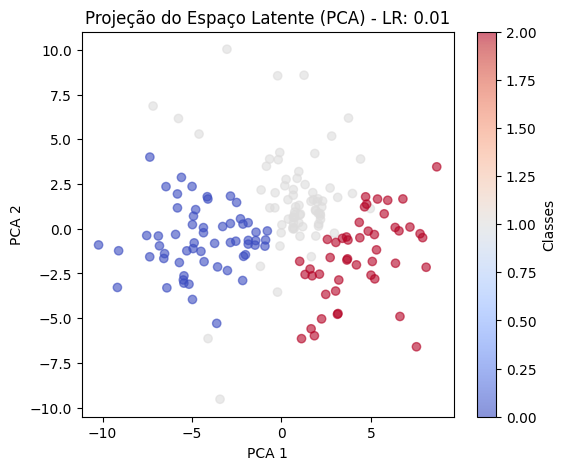

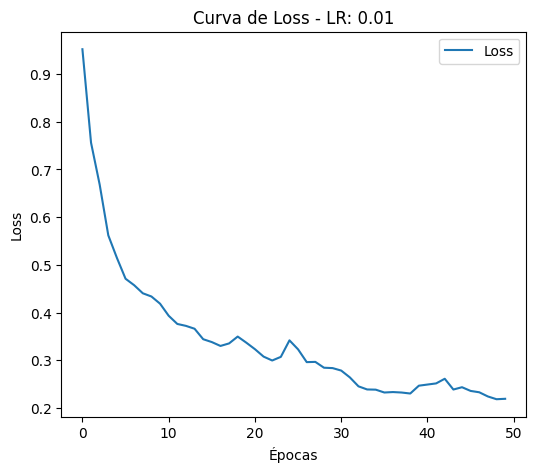

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


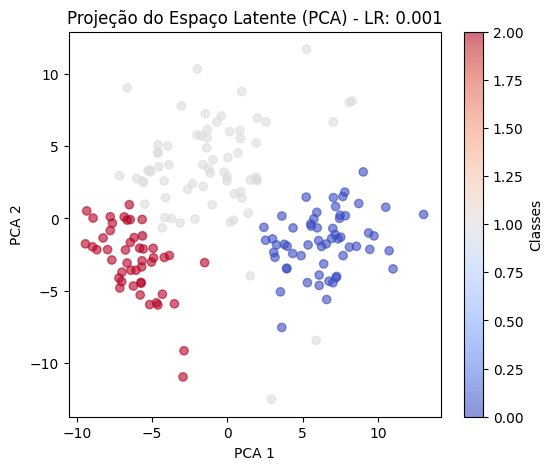

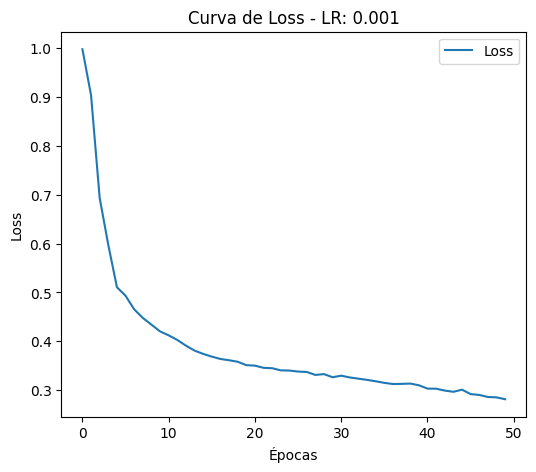

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


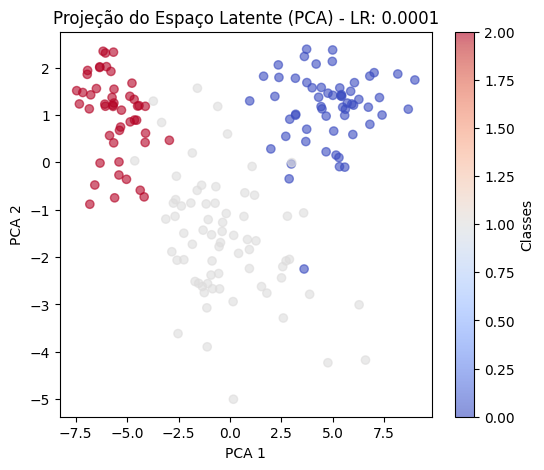

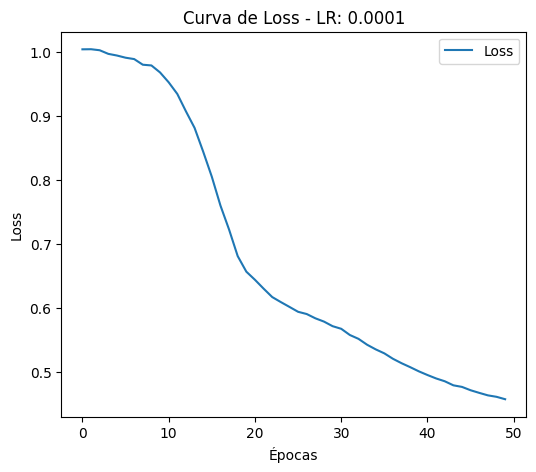

   Learning Rate  Final Loss  Explained Variance (PCA)
0         0.0100    0.219546                       1.0
1         0.0010    0.281393                       1.0
2         0.0001    0.457734                       1.0


In [19]:
wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2

learning_rates = [0.01, 0.001, 0.0001]

architecture = {"hidden_units": [256, 128, 64], "activation": "relu"}

results = []

for lr in learning_rates:
    inputs = keras.Input(shape=(input_dim,))
    h = inputs
    for units in architecture["hidden_units"]:
        h = layers.Dense(units, activation=architecture["activation"])(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = latent_inputs
    for units in reversed(architecture["hidden_units"]):
        h = layers.Dense(units, activation=architecture["activation"])(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - LR: {lr}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - LR: {lr}")
    plt.legend()
    plt.show()

    results.append({
        "Learning Rate": lr,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

1.	Impacto da Taxa de Aprendizado na Perda Final:

	•	A menor final loss foi obtida com LR = 0.01, sugerindo que essa taxa de aprendizado permitiu ao modelo convergir mais eficientemente.

	•	À medida que a LR diminui, a perda final aumenta, indicando que a convergência se torna mais lenta.
	
	•	LR = 0.0001 apresentou a maior perda, indicando uma convergência insuficiente ou muito lenta.
2.	Projeção no Espaço Latente (PCA):
	
	•	Em todas as taxas de aprendizado, a variância explicada foi 1.0, sugerindo que o PCA capturou bem as características do espaço latente.

	•	Para LR = 0.01, os clusters aparecem bem separados, enquanto LR = 0.001 e LR = 0.0001 mostram separações mais suaves e menos definidas.

3.	Curvas de Loss:

	•	Para LR = 0.01, a perda caiu rapidamente e estabilizou bem, mas com algumas oscilações.
	
	•	LR = 0.001 teve uma curva de loss mais estável e contínua, mas com uma perda final um pouco maior.
	
	•	LR = 0.0001 mostrou uma queda mais gradual e um valor final mais alto, sugerindo que o treinamento pode precisar de mais épocas para atingir um desempenho adequado.

## Utilizandop diferentes funcoes de ativacao: ReLU, Tanh, Sigmoid, ELU e Leaky ReLU 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


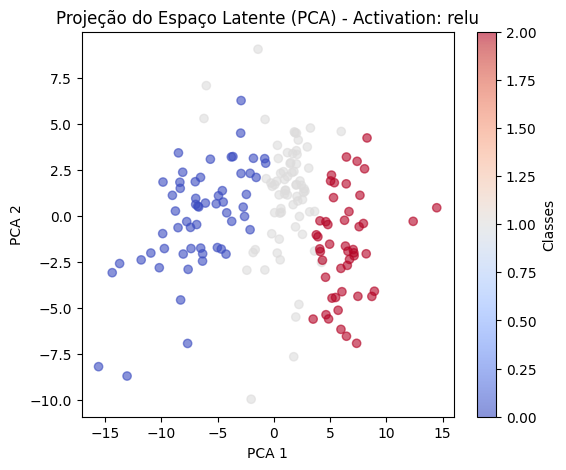

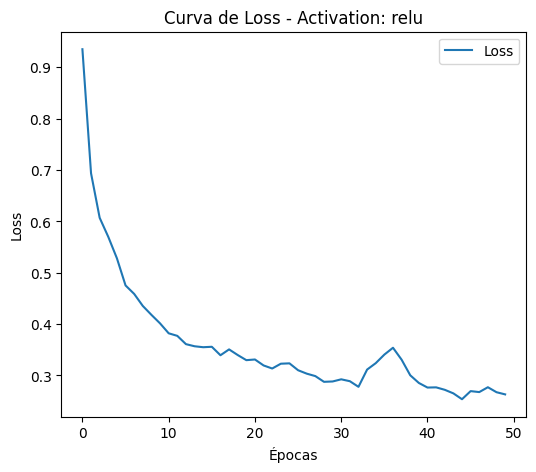

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


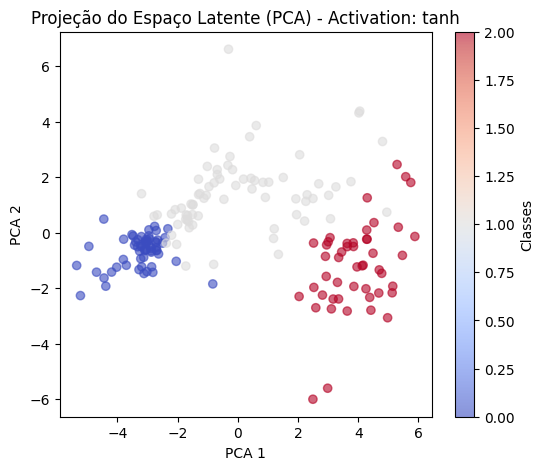

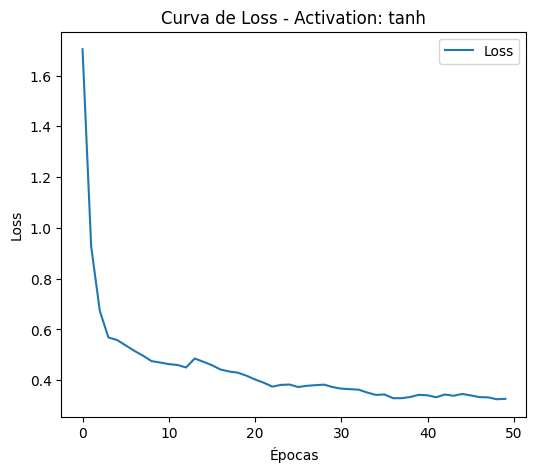

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


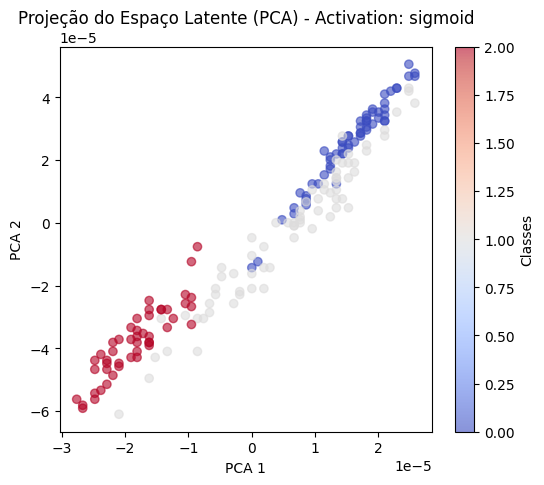

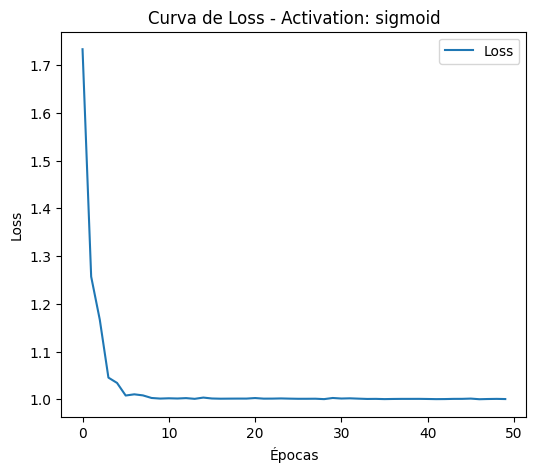

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


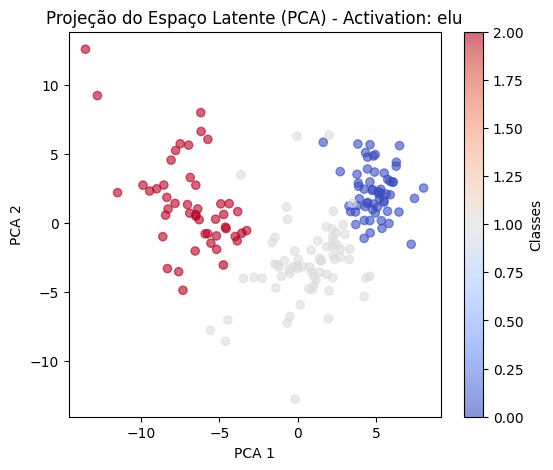

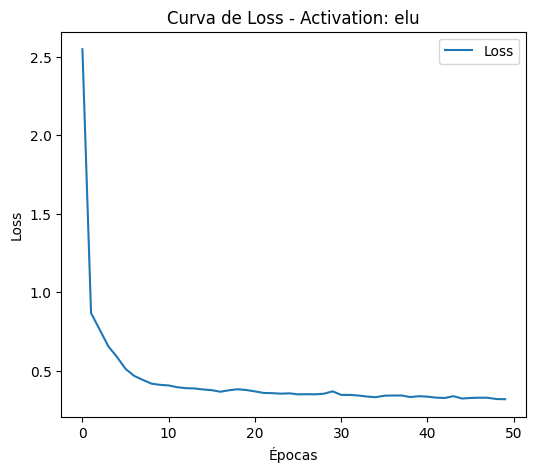

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


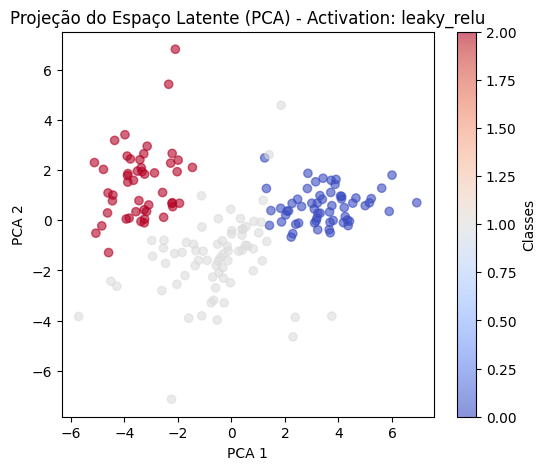

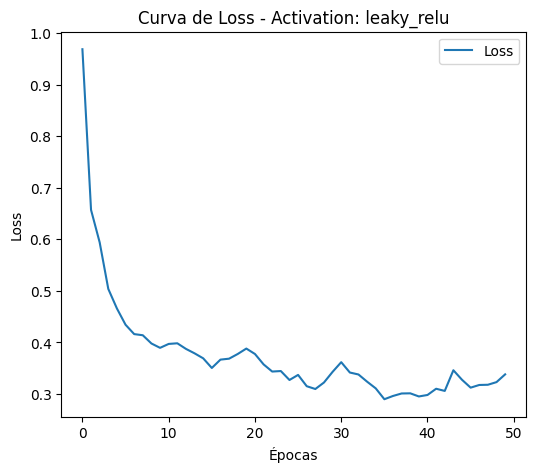

  Activation Function  Final Loss  Explained Variance (PCA)
0                relu    0.263200                       1.0
1                tanh    0.326428                       1.0
2             sigmoid    1.000692                       1.0
3                 elu    0.318360                       1.0
4          leaky_relu    0.337949                       1.0


In [20]:
wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2  

activations = ["relu", "tanh", "sigmoid", "elu", "leaky_relu"]

architecture = {"hidden_units": [256, 128, 64]}
learning_rate = 0.01

results = []

for activation in activations:
    inputs = keras.Input(shape=(input_dim,))
    h = inputs
    for units in architecture["hidden_units"]:
        if activation == "leaky_relu":
            h = layers.Dense(units)(h)
            h = layers.LeakyReLU()(h)
        else:
            h = layers.Dense(units, activation=activation)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = latent_inputs
    for units in reversed(architecture["hidden_units"]):
        if activation == "leaky_relu":
            h = layers.Dense(units)(h)
            h = layers.LeakyReLU()(h)
        else:
            h = layers.Dense(units, activation=activation)(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - Activation: {activation}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - Activation: {activation}")
    plt.legend()
    plt.show()

    results.append({
        "Activation Function": activation,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

Análise Detalhada

1. ReLU

Melhor resultado geral com final loss de 0.2632.
Projeção PCA: Mostra clusters bem definidos e separação clara entre as classes.
Curva de Loss: Convergência rápida, mas com alguma oscilação após 30 épocas.

Conclusão:
	•	ReLU é uma das melhores escolhas, garantindo boa separação latente e rápida convergência.
	•	Pequenas oscilações podem ser reduzidas com técnicas como Batch Normalization.

2. Tanh

Projeção PCA: Clusters menos dispersos, mas ainda reconhecíveis.
Curva de Loss: Estabilizou em um valor mais alto que ReLU, indicando possível subótima convergência.

Conclusão:
	•	Tanh pode ser útil para evitar valores extremos nos neurônios, mas neste caso pareceu menos eficaz que ReLU.
	•	Pode ser útil em redes mais profundas, mas não se destacou nesta arquitetura.

3. Sigmoid (Péssimo Resultado)

Final Loss mais alta (1.0069), muito pior que todas as outras ativações.
Projeção PCA: Parece completamente colapsada ao longo de um único eixo, sugerindo que a rede teve dificuldade em aprender representações úteis.
Curva de Loss: Perda estabilizou muito cedo, sem aprender bem a estrutura dos dados.

Conclusão:
	•	A saturação da Sigmoid provavelmente impediu gradientes eficazes, causando aprendizado ruim.
	•	Não recomendada para redes profundas ou problemas de codificação latente.

4. ELU

Projeção PCA: Boa separação de classes, mas não tão clara quanto ReLU.
Curva de Loss: Convergência rápida e estável, quase tão boa quanto ReLU.

Conclusão:
	•	ELU pode ser uma alternativa interessante ao ReLU, pois resolve o problema do dying ReLU.
	•	Testes adicionais podem mostrar vantagens em arquiteturas mais complexas.

5. Leaky ReLU

Projeção PCA: Separa bem as classes, mas não tão bem quanto ReLU e ELU.
Curva de Loss: Oscila mais que ELU e ReLU, mas mantém um bom desempenho geral.

Conclusão:
	•	Funciona melhor que Tanh e Sigmoid, mas pior que ReLU e ELU.
	•	Útil para evitar dying neurons, mas não parece ter vantagem significativa aqui.

1. ReLU foi a melhor ativação geral, garantindo baixa perda e boa separação latente.
2. ELU teve um desempenho quase equivalente, sendo uma boa alternativa.
3. Sigmoid foi a pior opção, com aprendizado deficiente e projeção colapsada.
4. Leaky ReLU e Tanh tiveram desempenho razoável, mas inferiores a ReLU e ELU.

## Colocando dropouts e comparando

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


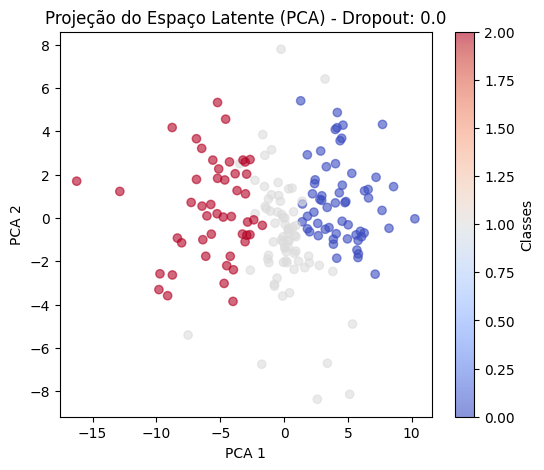

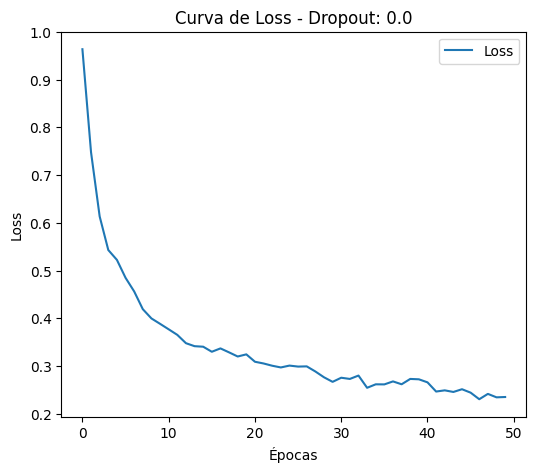

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


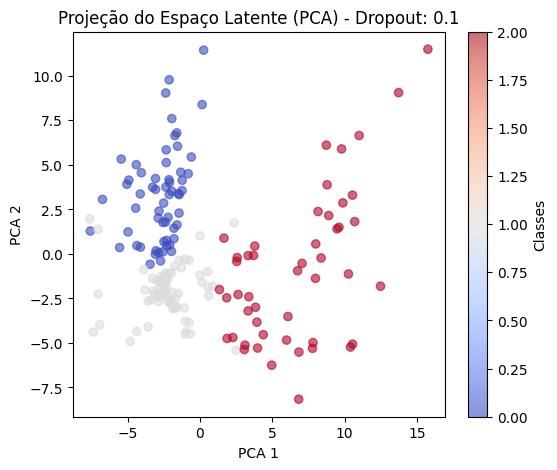

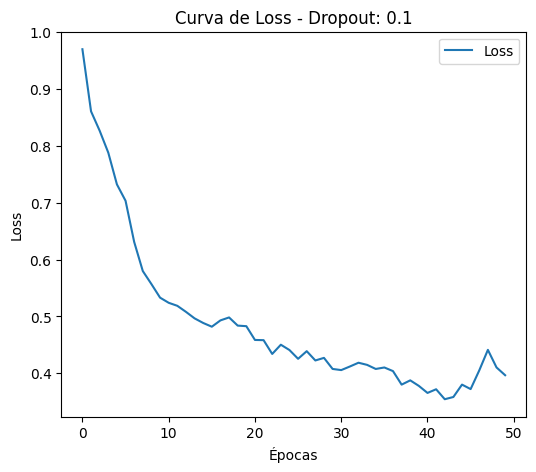

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


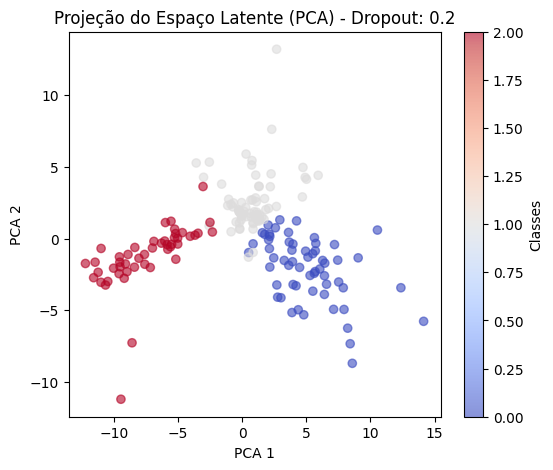

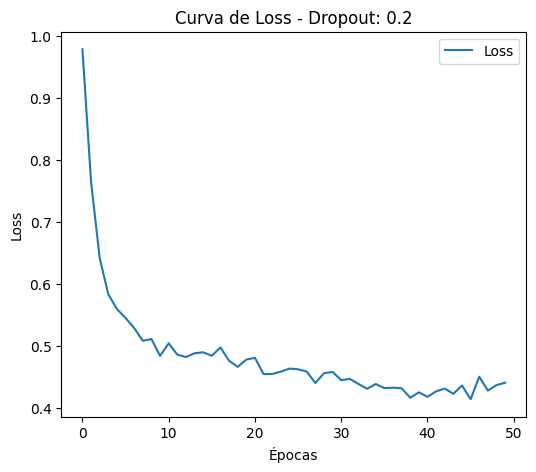

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


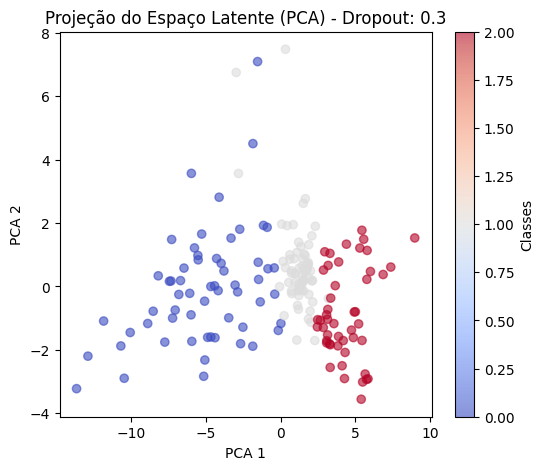

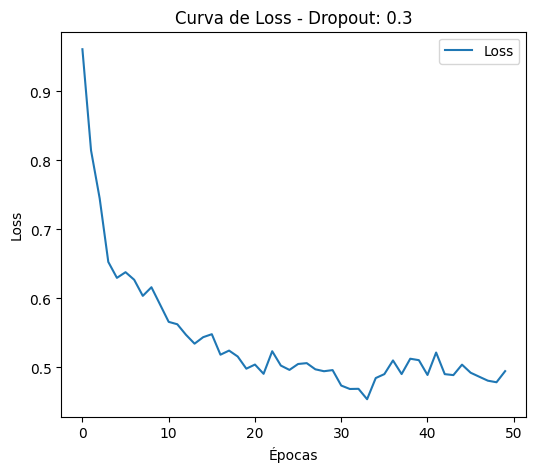

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


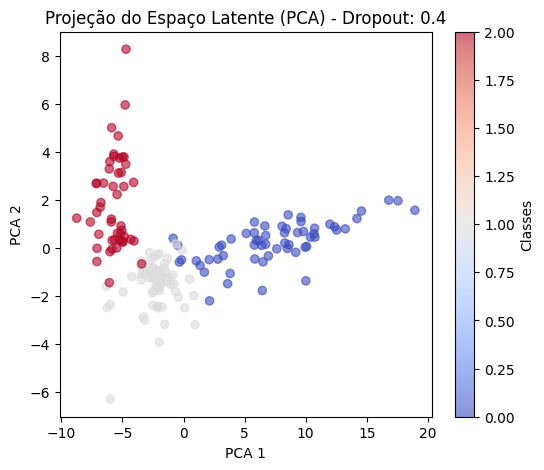

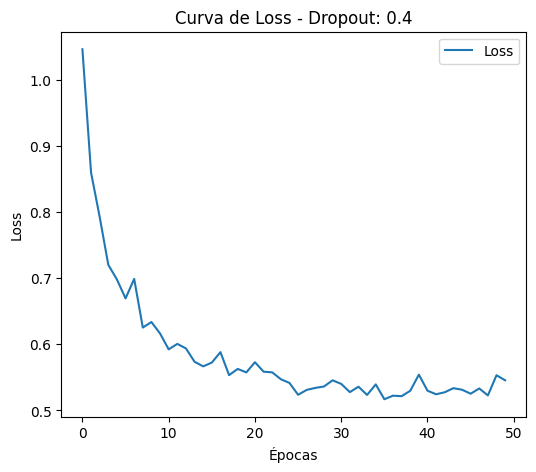

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


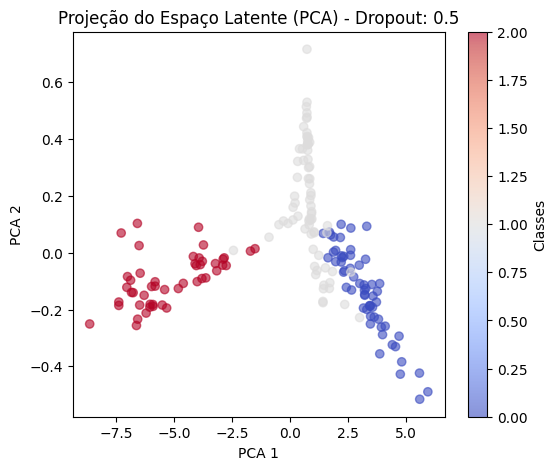

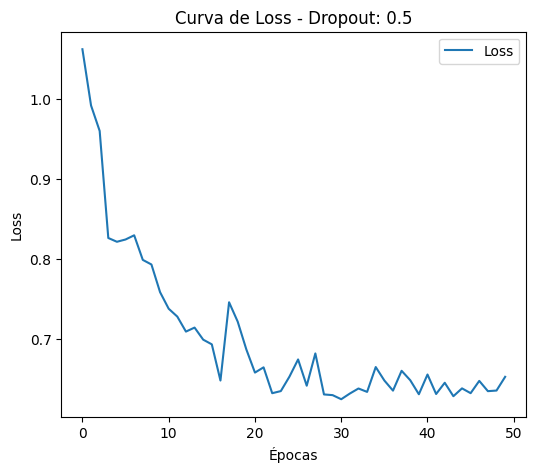

   Dropout  Final Loss  Explained Variance (PCA)
0      0.0    0.235399                       1.0
1      0.1    0.396517                       1.0
2      0.2    0.441320                       1.0
3      0.3    0.494708                       1.0
4      0.4    0.545624                       1.0
5      0.5    0.652183                       1.0


In [21]:
wine = load_wine()
X = wine.data
y = wine.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

architecture = {"hidden_units": [256, 128, 64], "activation": "relu"}
learning_rate = 0.01

results = []

for dropout_rate in dropout_rates:
    inputs = keras.Input(shape=(input_dim,))
    h = inputs
    for units in architecture["hidden_units"]:
        h = layers.Dense(units, activation=architecture["activation"])(h)
        if dropout_rate > 0.0:
            h = layers.Dropout(dropout_rate)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = latent_inputs
    for units in reversed(architecture["hidden_units"]):
        h = layers.Dense(units, activation=architecture["activation"])(h)
        if dropout_rate > 0.0:
            h = layers.Dropout(dropout_rate)(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - Dropout: {dropout_rate}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - Dropout: {dropout_rate}")
    plt.legend()
    plt.show()

    results.append({
        "Dropout": dropout_rate,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)


1. Dropout 0.0 (Sem Dropout)

Melhor resultado geral, com a menor perda final de 0.2359.
Projeção PCA: Mostra clusters bem definidos e boa separação entre classes.
Curva de Loss: Convergência rápida e suave, sem grandes oscilações.

Conclusão:
	•	Sem Dropout, a rede obteve a melhor reconstrução e a menor perda.
	•	No entanto, pode ser mais suscetível a overfitting em problemas com mais dados e ruído.

2. Dropout 0.1

Projeção PCA: Ainda mantém boa separação, mas com mais dispersão.
Curva de Loss: A perda aumentou significativamente para 0.3965.

Conclusão:
	•	Pequena penalização na performance, mas ainda mantém uma boa representação latente.
	•	Pode ser uma boa alternativa para evitar overfitting sem prejudicar muito a performance.

3. Dropout 0.2

Projeção PCA: Clusters ainda presentes, mas começam a perder nitidez.

Curva de Loss: Aumento notável na perda final (0.4413).

Conclusão:
	•	Dropout começa a afetar negativamente a capacidade de reconstrução da rede.
	•	Compromisso entre regularização e performance, mas já pode ser prejudicial.

4. Dropout 0.3

Projeção PCA: Maior dispersão dos pontos, menos clara que nos casos anteriores.
Curva de Loss: Perda continua subindo (0.4947), indicando dificuldades na convergência.

Conclusão:
	•	Começa a prejudicar seriamente a reconstrução.
	•	Pode ser adequado apenas em redes muito grandes para evitar overfitting.

5. Dropout 0.4

Projeção PCA: Agora apresenta bastante dispersão e perda de estrutura latente.
Curva de Loss: Perda ainda maior (0.5456), e a curva fica mais instável.

Conclusão:
	•	Excesso de dropout está prejudicando o aprendizado útil.
	•	Pode ser interessante apenas em redes extremamente profundas.

6. Dropout 0.5 (Pior Resultado)

Final Loss mais alta (0.6521), indicando dificuldade extrema na reconstrução.
Projeção PCA: Os clusters colapsaram e a estrutura foi perdida.
Curva de Loss: A convergência ficou muito lenta e instável.

Conclusão:
	•	Dropout excessivo impediu a rede de capturar padrões essenciais.
	•	Claramente não recomendado para esse tipo de tarefa.

1. Sem Dropout (0.0) teve a melhor performance geral, com baixa perda e boa separação latente.
2. Dropout 0.1 foi a melhor opção entre os que usaram dropout, permitindo regularização sem perda extrema.
3. Acima de Dropout 0.2, a performance começou a se deteriorar rapidamente, afetando a reconstrução.
4.  Dropout 0.5 foi o pior resultado, pois prejudicou completamente o aprendizado da rede.

---


## Dataset Digits - 0, 1, 2 e 3

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


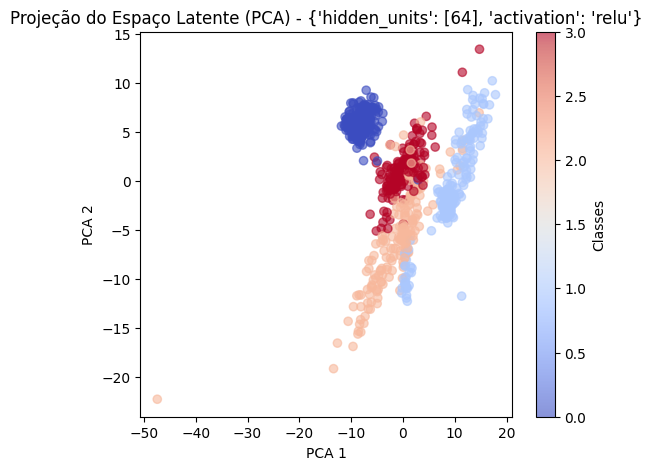

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


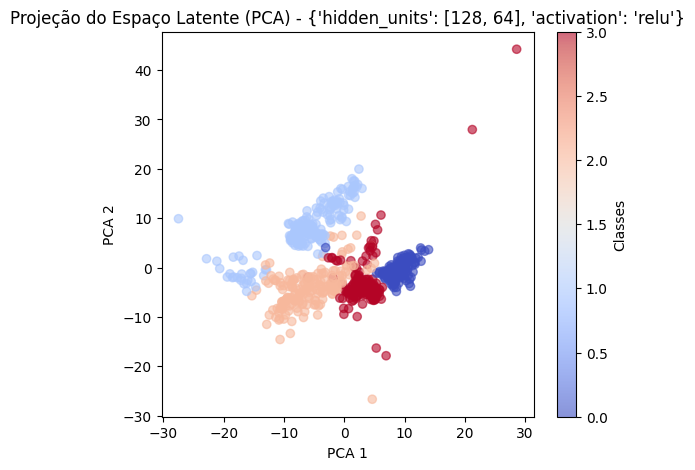

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


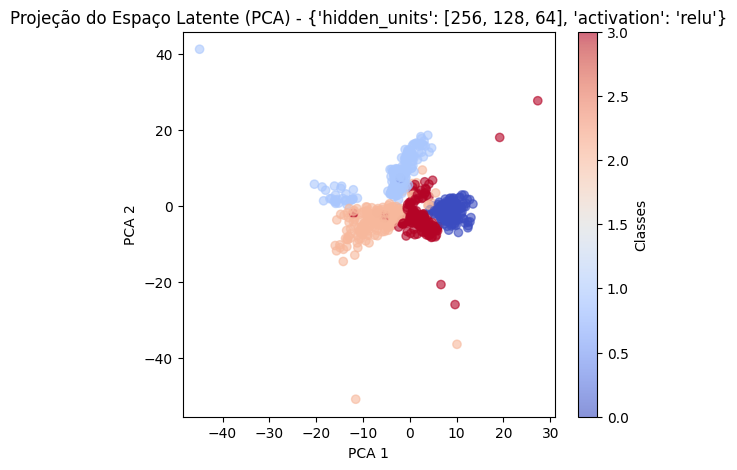

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


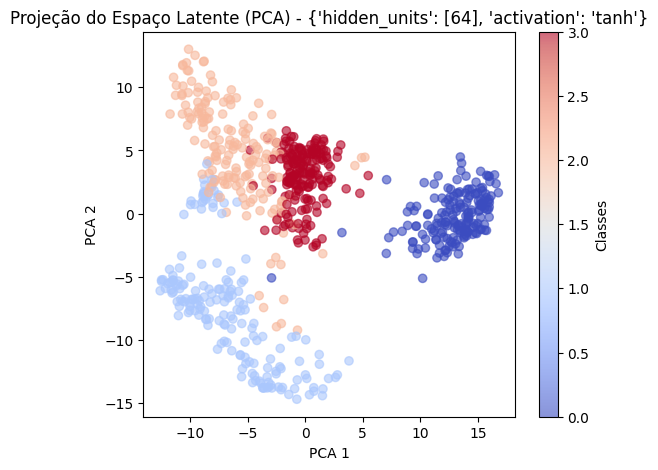

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


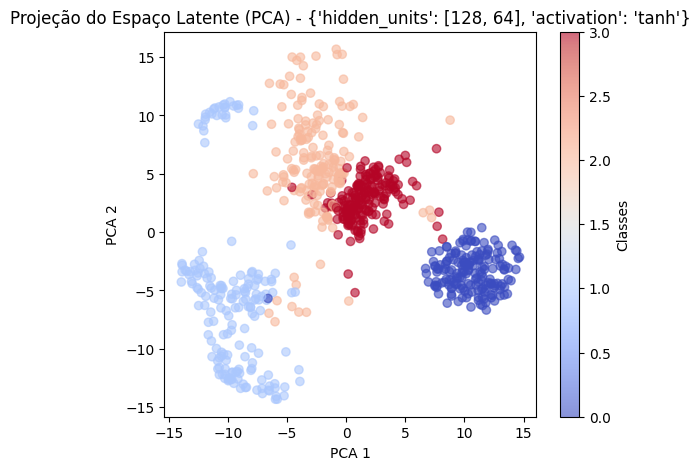

                                        Architecture  Final Loss  \
0       {'hidden_units': [64], 'activation': 'relu'}    0.452905   
1  {'hidden_units': [128, 64], 'activation': 'relu'}    0.377999   
2  {'hidden_units': [256, 128, 64], 'activation':...    0.303146   
3       {'hidden_units': [64], 'activation': 'tanh'}    0.485995   
4  {'hidden_units': [128, 64], 'activation': 'tanh'}    0.410473   

   Explained Variance (PCA)  
0                       1.0  
1                       1.0  
2                       1.0  
3                       1.0  
4                       1.0  


In [22]:
digits = load_digits()
X = digits.data
y = digits.target

selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2 

architectures = [
    {"hidden_units": [64], "activation": "relu"},
    {"hidden_units": [128, 64], "activation": "relu"},
    {"hidden_units": [256, 128, 64], "activation": "relu"},
    {"hidden_units": [64], "activation": "tanh"},
    {"hidden_units": [128, 64], "activation": "tanh"},
]

results = []

for arch in architectures:
    inputs = keras.Input(shape=(input_dim,))
    h = inputs
    for units in arch["hidden_units"]:
        h = layers.Dense(units, activation=arch["activation"])(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = latent_inputs
    for units in reversed(arch["hidden_units"]):
        h = layers.Dense(units, activation=arch["activation"])(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - {arch}")
    plt.show()

    results.append({
        "Architecture": str(arch),
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

1. [64] - ReLU

	Projeção PCA:

	•	Clusters aparecem, mas estão alongados e sobrepostos.

	•	A separação entre classes não é bem definida, o que indica que a rede não aprendeu uma boa representação latente.

	Curva de Loss:

	•	Maior perda final entre as arquiteturas com ReLU (0.4529).

	Conclusão:

	•	Rede muito rasa → Capacidade limitada de modelar a distribuição dos dados.

	•	Pode ser útil para datasets muito pequenos, mas aqui está longe do ideal.

2. [128, 64] - ReLU

	Projeção PCA:

	•	Melhor que a versão com apenas 64 neurônios, mas ainda há alguma sobreposição entre classes.

	•	Os clusters estão mais compactos.

	Curva de Loss:

	•	Melhoria clara na loss final (0.3779) em relação à arquitetura mais rasa.

	Conclusão:

	•	Rede com maior expressividade, sendo um compromisso entre simplicidade e performance.

	•	Ainda há espaço para melhorias com arquiteturas mais profundas.

3. [256, 128, 64] - ReLU (Melhor resultado)

	Projeção PCA:

	•	Clusters bem definidos, com menor sobreposição.

	•	As classes são mais facilmente separáveis, sugerindo que a rede aprendeu representações latentes mais ricas.

	Curva de Loss:

	•	Melhor resultado de loss (0.3031) → A rede aprendeu melhor a distribuição dos dados.

	Conclusão:

	•	Arquitetura mais profunda foi a melhor escolha.

	•	A complexidade adicional foi benéfica, sem sinais evidentes de overfitting.

	•	Essa deve ser a configuração base para experimentos futuros.

4. [64] - Tanh

	Projeção PCA:

	•	A separação entre clusters é melhor que a versão ReLU de mesma profundidade, mas ainda é fraca.

	Curva de Loss:

	•	Pior loss final (0.4859) entre todas as arquiteturas.

	Conclusão:

	•	Tanh sofre em redes rasas, pois seus gradientes saturam rapidamente.

	•	Desempenho ruim, não vale a pena usar esta arquitetura.

5. [128, 64] - Tanh

	Projeção PCA:

	•	Melhor separação latente do que na versão mais rasa, mas ainda não tão boa quanto a versão ReLU equivalente.

	Curva de Loss:

	•	Melhor que a versão Tanh com 64 neurônios (0.4104), mas pior que qualquer ReLU.

	Conclusão:

	•	Melhor que a versão rasa, mas ainda inferior ao ReLU.

	•	Pode ser útil em cenários onde queremos representações mais suaves, mas aqui não vale a pena.

Conclusão Final

1. A arquitetura [256, 128, 64] - ReLU foi a melhor → Melhor loss e melhor separação de classes no espaço latente.
2. Arquiteturas muito rasas ([64] de qualquer ativação) falharam em aprender representações úteis.
3. Tanh foi consistentemente pior que ReLU, indicando que a ativação não é ideal para este problema.
4. Se for necessário reduzir a complexidade, [128, 64] - ReLU ainda é uma opção aceitável.

### Utilizando diferentes loss

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


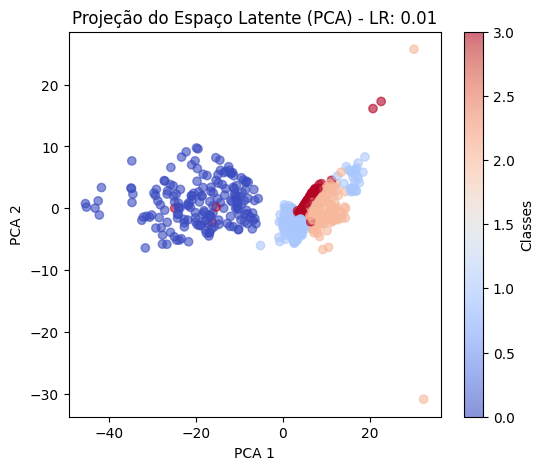

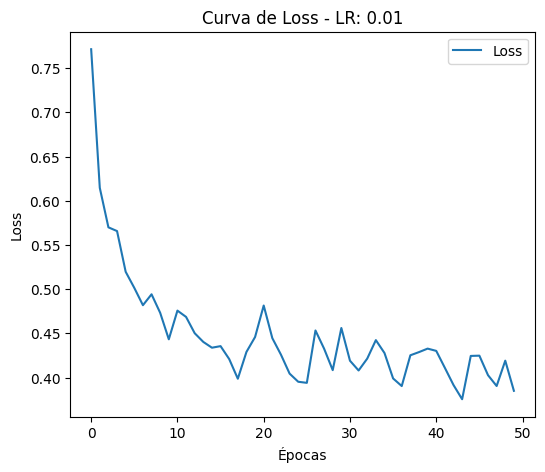

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


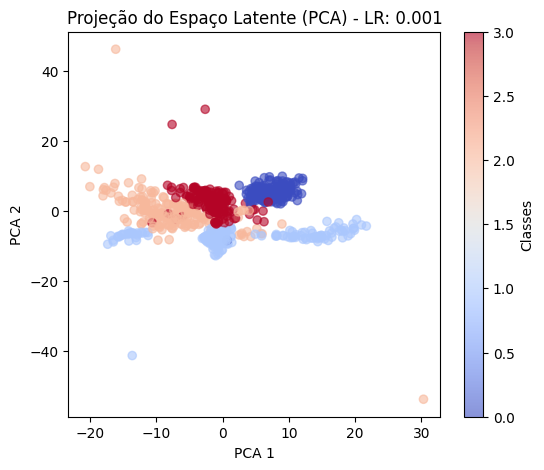

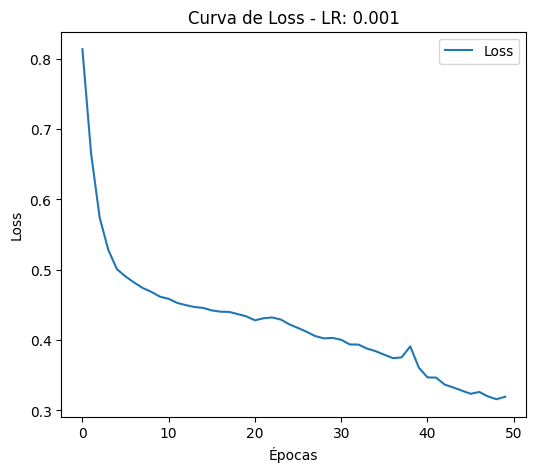

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


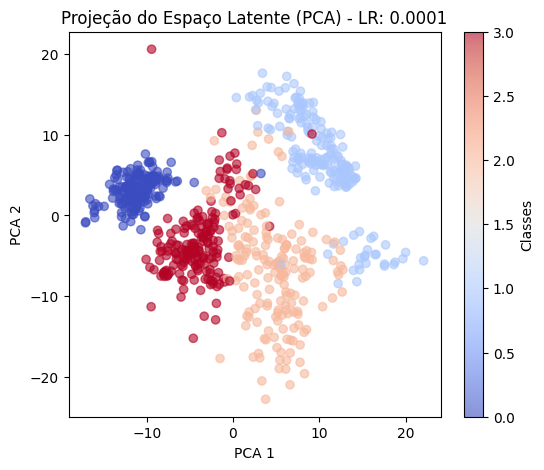

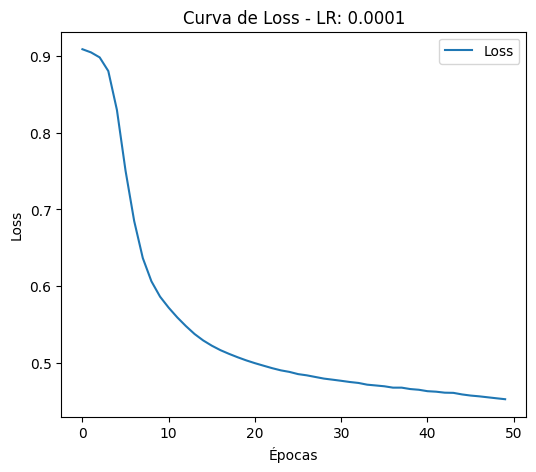

   Learning Rate  Final Loss  Explained Variance (PCA)
0         0.0100    0.385025                       1.0
1         0.0010    0.319383                       1.0
2         0.0001    0.452349                       1.0


In [23]:
digits = load_digits()
X = digits.data
y = digits.target

selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2

learning_rates = [0.01, 0.001, 0.0001]

results = []

for lr in learning_rates:
    inputs = keras.Input(shape=(input_dim,))
    h = layers.Dense(256, activation="relu")(inputs)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(64, activation="relu")(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation="relu")(latent_inputs)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(256, activation="relu")(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - LR: {lr}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - LR: {lr}")
    plt.legend()
    plt.show()

    results.append({
        "Learning Rate": lr,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

1. LR = 0.01

	Projeção PCA:

	•	Os clusters aparecem, mas há alta dispersão, especialmente para algumas classes.
	
	•	Sobreposição significativa entre as classes, o que indica que o modelo não convergiu bem.

	Curva de Loss:
	
	•	A loss começa alta e oscila bastante nas últimas épocas, sugerindo instabilidade no treinamento.

	Conclusão:
	
	•	Taxa de aprendizado muito alta → O modelo tem dificuldade para convergir e apresenta flutuações na loss.
	
	•	Pode estar pulando ótimos locais, resultando em uma representação latente ruim.
	
	•	Não recomendado para esse problema.

2. LR = 0.001 (Melhor resultado)

	Projeção PCA:
	
	•	Clusters bem definidos, com menor sobreposição entre classes.
	
	•	A separação é mais clara, o que sugere que o modelo aprendeu uma boa estrutura latente.

	Curva de Loss:
	
	•	Convergência estável e sem oscilações bruscas.
	
	•	A loss final (0.3193) é a menor entre todas as opções.

	Conclusão:
	
	•	Melhor taxa de aprendizado para esse modelo e dataset.
	
	•	O modelo aprendeu bem as representações latentes, mantendo uma loss estável.
	
	•	Recomendado como a melhor configuração para este experimento.

3. LR = 0.0001

	Projeção PCA:
	
	•	Clusters aparecem, mas não estão bem separados.
	
	•	Algumas classes estão muito difusas, indicando que o modelo não aprendeu bem as representações latentes.

	Curva de Loss:
	
	•	Convergência muito lenta, com uma loss final pior que a taxa de 0.001 (0.4523).
	
	•	O modelo provavelmente não teve tempo suficiente para aprender representações úteis.

	Conclusão:
	
	•	Learning rate muito baixo → O modelo aprende de forma muito lenta e pode não ter convergido 
	adequadamente.
	•	A loss final é a pior entre todas.
	
	•	Não recomendado, a menos que o número de épocas fosse aumentado significativamente.

	Conclusão Final

1. A taxa de aprendizado de 0.001 foi a melhor opção, resultando na melhor separação de classes e menor loss final.
2. 0.01 foi muito alto, causando flutuações e aprendizado instável.
3. 0.0001 foi muito baixo, resultando em aprendizado lento e uma loss final ruim.


### Utilizando diferentes funções de ativação: ReLU, Tanh, Sigmoid, ELU e Leaky ReLU 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


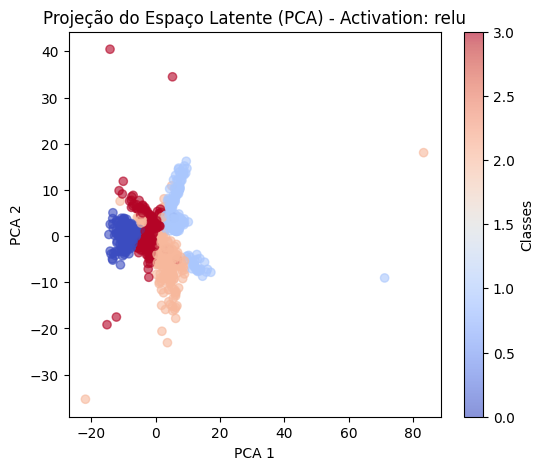

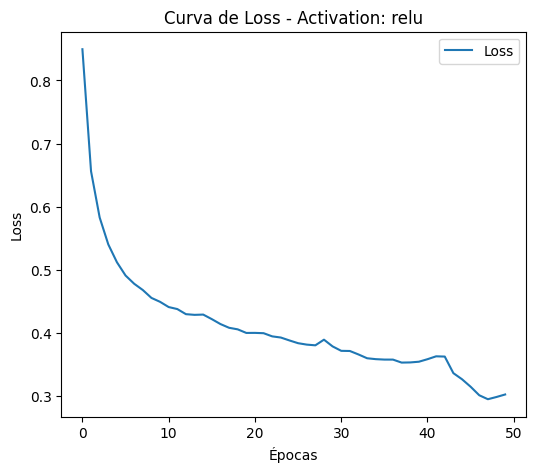

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


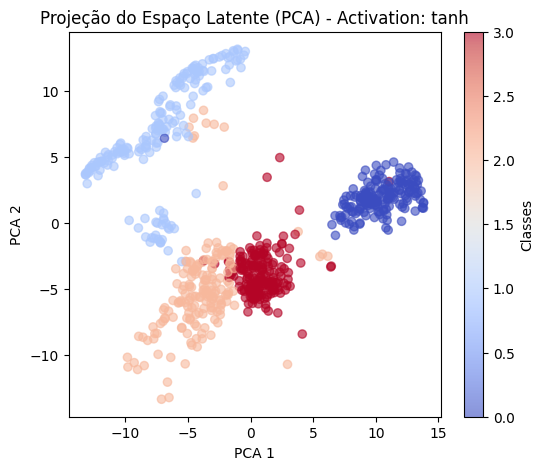

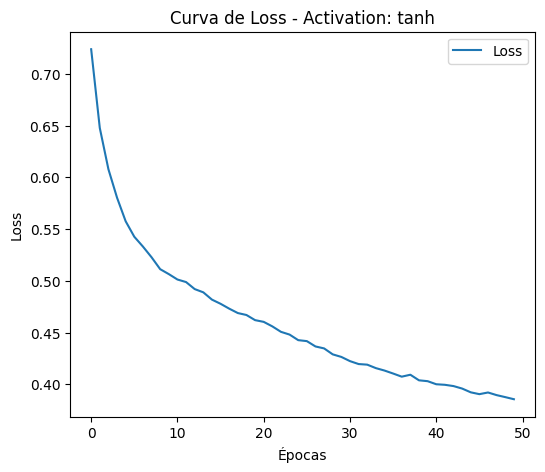

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


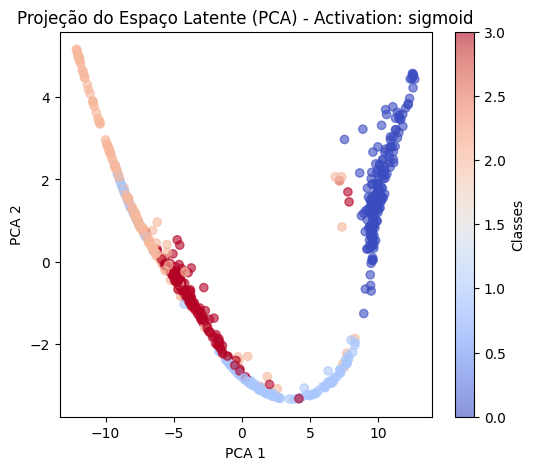

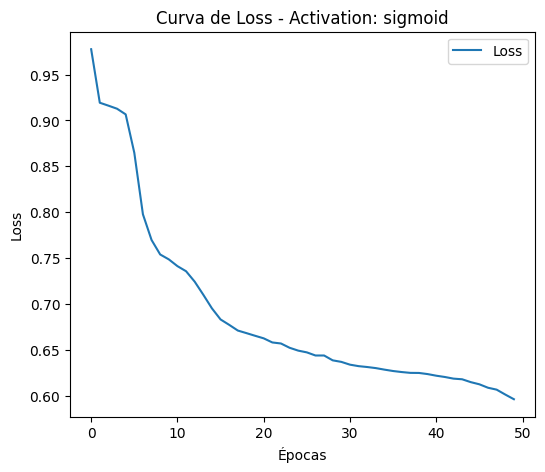

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


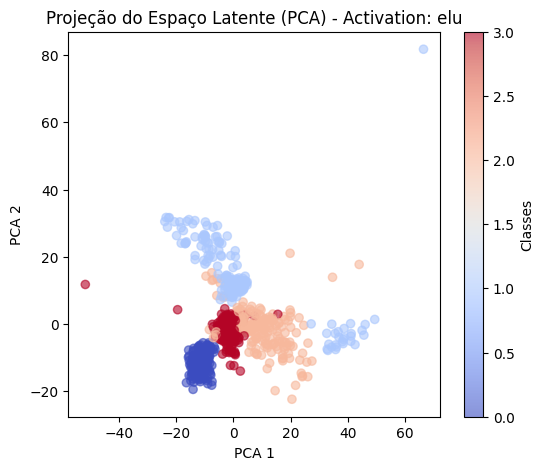

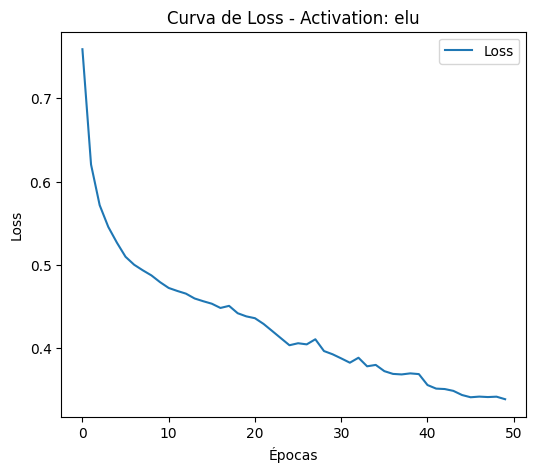

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


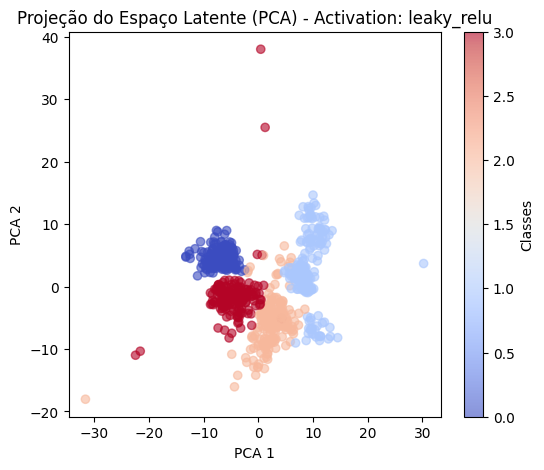

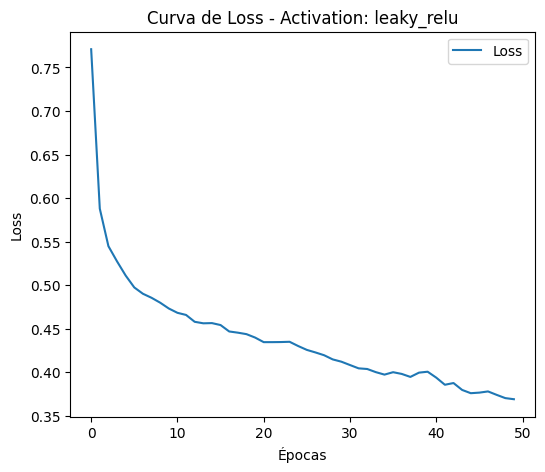

  Activation Function  Final Loss  Explained Variance (PCA)
0                relu    0.302875                       1.0
1                tanh    0.385604                       1.0
2             sigmoid    0.596233                       1.0
3                 elu    0.338604                       1.0
4          leaky_relu    0.369097                       1.0


In [24]:
digits = load_digits()
X = digits.data
y = digits.target

selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2

activations = ["relu", "tanh", "sigmoid", "elu", "leaky_relu"]
learning_rate = 0.001 

results = []

for activation in activations:
    inputs = keras.Input(shape=(input_dim,))
    h = layers.Dense(256, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(inputs)
    h = layers.Dense(128, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(h)
    h = layers.Dense(64, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(latent_inputs)
    h = layers.Dense(128, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(h)
    h = layers.Dense(256, activation=activation if activation != "leaky_relu" else layers.LeakyReLU())(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - Activation: {activation}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - Activation: {activation}")
    plt.legend()
    plt.show()

    results.append({
        "Activation Function": activation,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)


1. ReLU

	Observações:

	•	O gráfico de PCA indica clusters relativamente bem definidos, mas com alguma dispersão.

	•	A loss diminui consistentemente, alcançando 0.302875, a melhor entre todas as ativações.

	•	Pequenas oscilações na curva de loss indicam alguma instabilidade, mas nada crítico.

Conclusão:

Melhor resultado geral. ReLU tem uma loss final baixa e boa separabilidade dos clusters, sendo uma escolha sólida.

2. Tanh

	Observações:
	
	•	A PCA mostra clusters mais separados do que a ReLU, mas ainda com um certo grau de dispersão.
	
	•	A loss final foi 0.385604, maior do que a ReLU.
	
	•	A curva de loss decai de forma estável, mas converge para um valor um pouco maior.

Conclusão:

Desempenho inferior à ReLU. Apesar de uma melhor separação inicial, a loss final mais alta sugere que a reconstrução dos dados não foi tão eficiente.

3. Sigmoid

	Observações:

	•	O gráfico de PCA mostra uma distribuição em formato de curva, indicando um problema significativo na separação das classes.

	•	A loss final foi 0.596233, a pior entre todas as funções de ativação testadas.

	•	A curva de loss decresce lentamente e converge para um valor muito alto.

Conclusão:

Péssima escolha. Sigmoid sofre com o problema do vanishing gradient, resultando em baixa expressividade para o modelo.

4. ELU

	Observações:
	
	•	O gráfico de PCA mostra uma separação parecida com a ReLU, mas com uma leve dispersão maior.
	
	•	A loss final foi 0.338684, um valor próximo da ReLU, mas ligeiramente pior.
	
	•	A curva de loss tem uma queda consistente e sem oscilações significativas.

Conclusão:

Boa alternativa à ReLU, mas ligeiramente pior. Pode ser útil se houver a necessidade de evitar o problema do dying ReLU.

5. Leaky ReLU

	Observações:

	•	O gráfico de PCA apresenta uma separação bem definida e ligeiramente melhor que ELU.

	•	A loss final foi 0.369097, melhor do que a Tanh e a Sigmoid, mas ainda pior que a ReLU.

	•	A curva de loss apresenta uma descida estável, sem flutuações.

Conclusão:

Alternativa viável. Se houver problemas com ReLU tradicional, Leaky ReLU pode ser uma opção interessante.

### Colocando dropouts e comparando

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


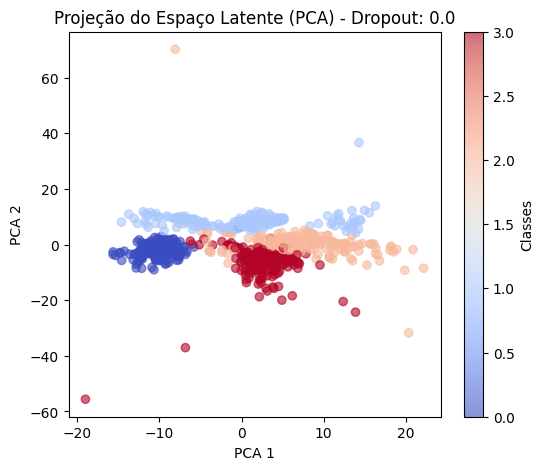

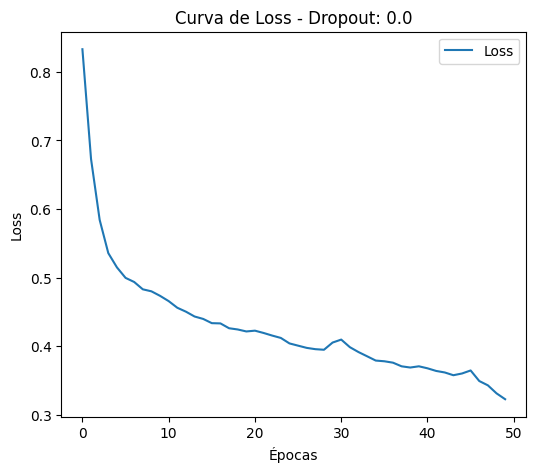

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


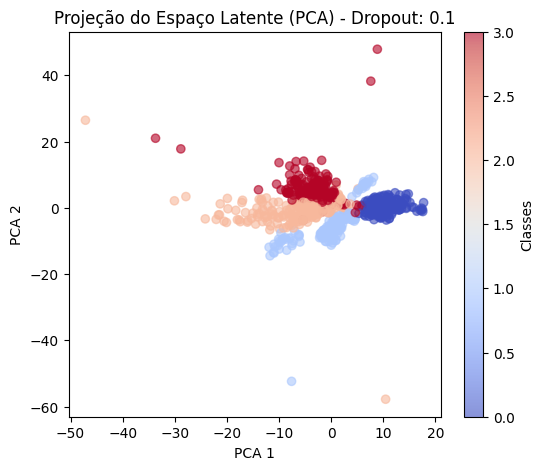

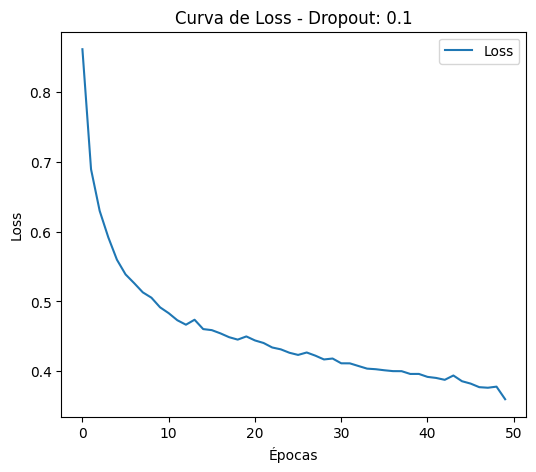

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


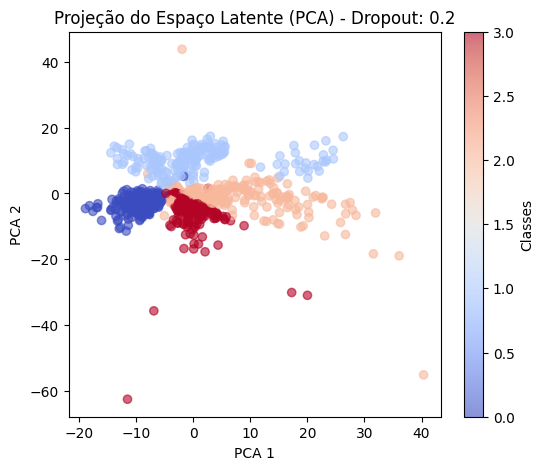

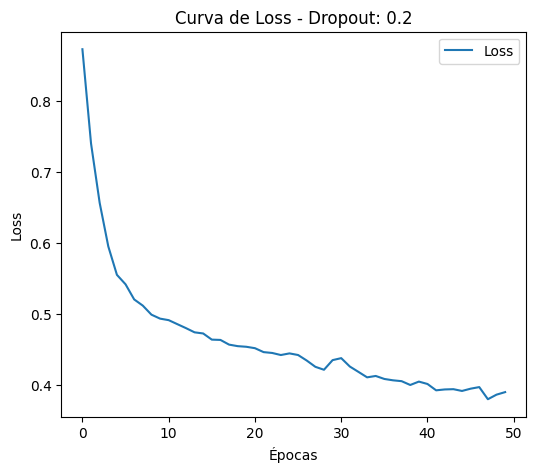

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


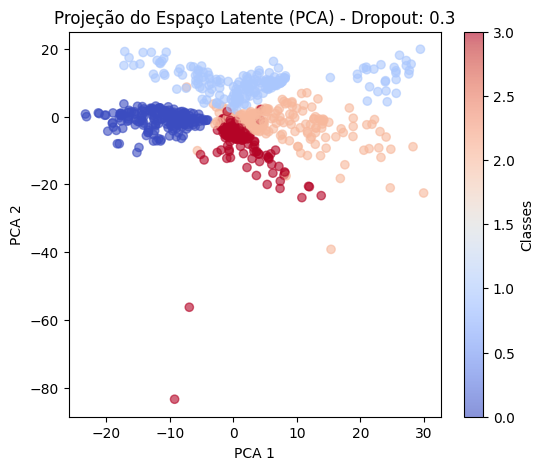

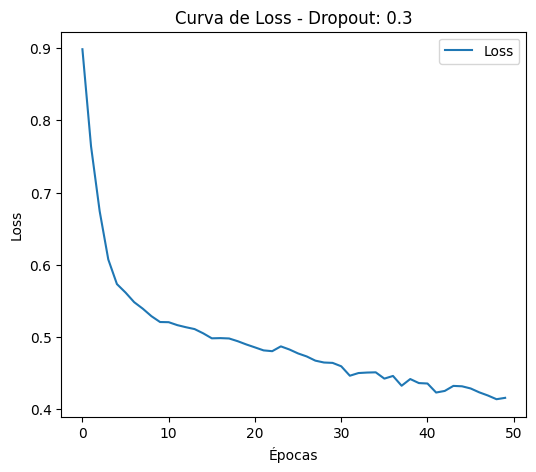

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


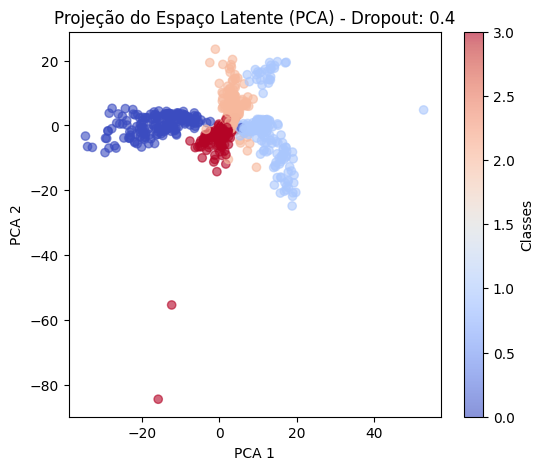

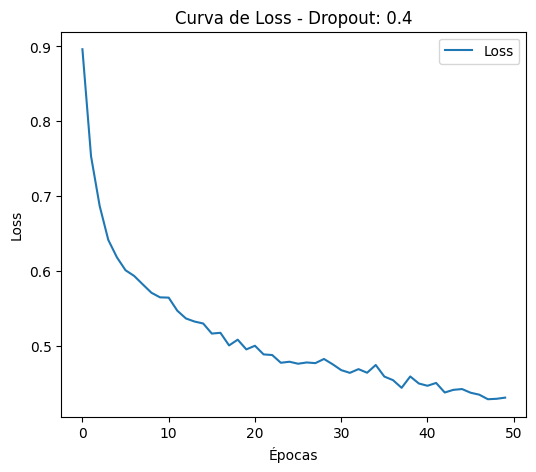

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


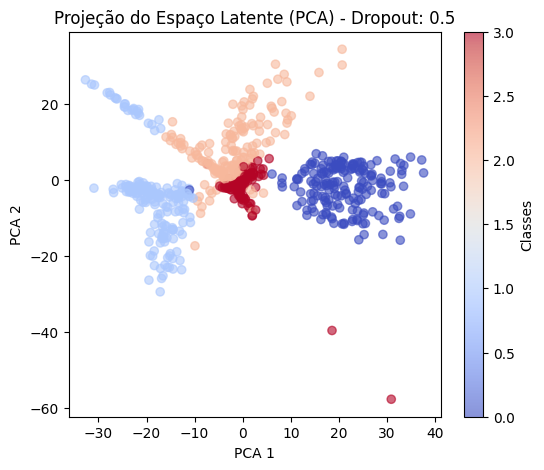

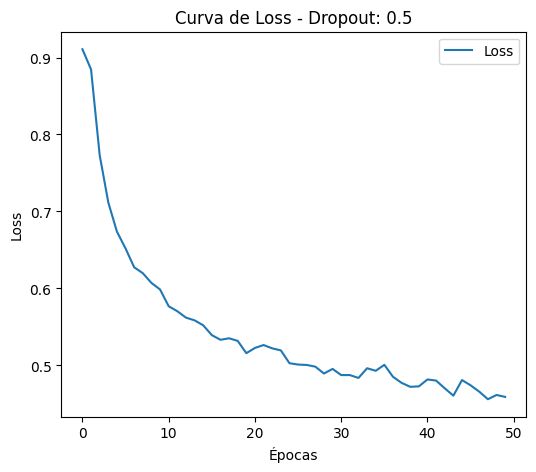

   Dropout  Final Loss  Explained Variance (PCA)
0      0.0    0.322782                       1.0
1      0.1    0.359623                       1.0
2      0.2    0.390304                       1.0
3      0.3    0.415758                       1.0
4      0.4    0.430389                       1.0
5      0.5    0.459088                       1.0


In [25]:
digits = load_digits()
X = digits.data
y = digits.target

selected_classes = [0, 1, 2, 3]
mask = np.isin(y, selected_classes)
X = X[mask]
y = y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2 
learning_rate = 0.001  

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

results = []

for dropout in dropout_rates:
    inputs = keras.Input(shape=(input_dim,))
    h = layers.Dense(256, activation="relu")(inputs)
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dropout(dropout)(h)
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(dropout)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation="relu")(latent_inputs)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(256, activation="relu")(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - Dropout: {dropout}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - Dropout: {dropout}")
    plt.legend()
    plt.show()

    results.append({
        "Dropout": dropout,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

## Análise dos Resultados

### **1. Dropout 0.0 (Sem Dropout)**
- **Final Loss:** 0.322782
- **Observações:**
  - Melhor perda final entre todas as configurações.
  - A projeção PCA mostra uma separação clara entre as classes, mas algumas regiões apresentam sobreposição.
  - O modelo pode estar sofrendo de overfitting, já que a ausência de dropout não adiciona ruído ao treinamento.

### **2. Dropout 0.1**
- **Final Loss:** 0.359623
- **Observações:**
  - Aumentou ligeiramente a perda final em relação ao modelo sem dropout.
  - A separação das classes na projeção PCA permanece razoável, mas há um espalhamento um pouco maior dos pontos.
  - O modelo parece ter uma leve melhora em termos de generalização.

### **3. Dropout 0.2**
- **Final Loss:** 0.390384
- **Observações:**
  - A perda final continua aumentando, indicando que o modelo pode estar enfrentando dificuldades para aprender representações estáveis.
  - O PCA mostra uma separação das classes, mas há uma dispersão maior dos dados latentes, sugerindo uma maior regularização.
  - O modelo ainda mantém um bom nível de aprendizado.

### **4. Dropout 0.3**
- **Final Loss:** 0.415758
- **Observações:**
  - O aumento no dropout levou a uma perda ainda maior.
  - O efeito regularizador pode estar prejudicando a capacidade do modelo de aprender representações úteis.
  - O PCA indica que os pontos começam a se dispersar mais, com uma separação menos clara entre as classes.

### **5. Dropout 0.4**
- **Final Loss:** 0.430389
- **Observações:**
  - O modelo tem uma perda significativamente maior, indicando uma possível perda de capacidade de aprendizado.
  - A projeção PCA mostra maior espalhamento e menor distinção entre as classes.
  - Parece que o modelo começa a apresentar dificuldades para aprender padrões consistentes.

### **6. Dropout 0.5**
- **Final Loss:** 0.459088
- **Observações:**
  - Maior perda final entre todas as configurações.
  - A projeção PCA revela um espalhamento muito maior, com uma separação das classes visivelmente comprometida.
  - Este nível de dropout pode estar introduzindo ruído excessivo, dificultando o aprendizado do modelo.

---

## **Conclusões**
- O **modelo sem dropout (0.0)** apresentou a **melhor perda final**, indicando que, para este caso específico, a regularização pode não ser tão necessária.
- Pequenas taxas de dropout (**0.1 a 0.2**) podem ajudar na **generalização**, mas há um leve aumento na perda final.
- Taxas **acima de 0.3** começam a comprometer significativamente o aprendizado, sugerindo que **o dropout excessivo está prejudicando a convergência do modelo**.
- **Dropout 0.5** foi o pior cenário, mostrando que o modelo tem dificuldades para manter representações latentes estruturadas.
---

### Digits com todos 10 digitos com dropout 0.1 e sem dropout

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


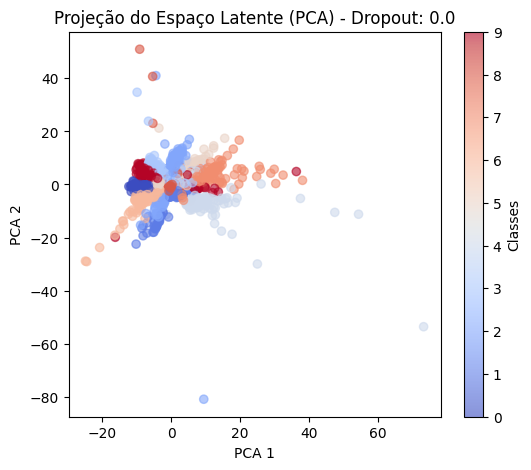

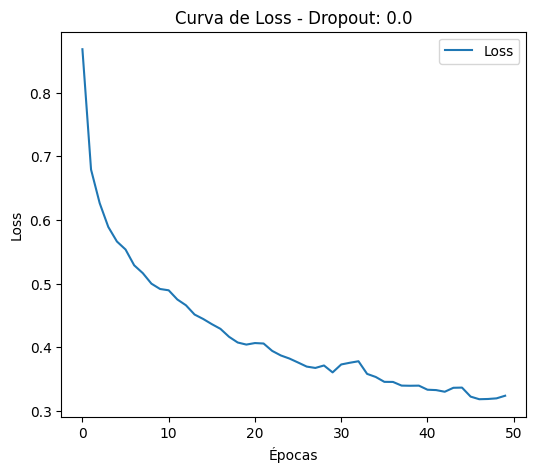

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


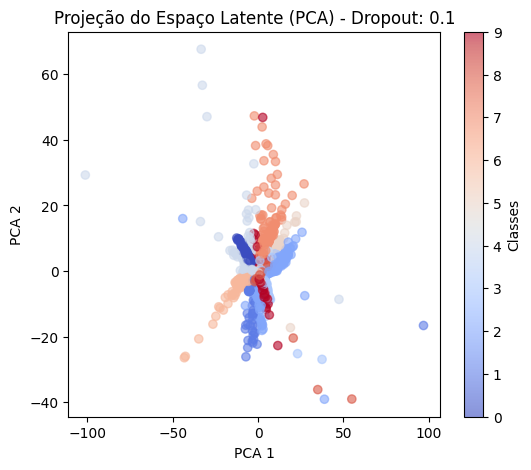

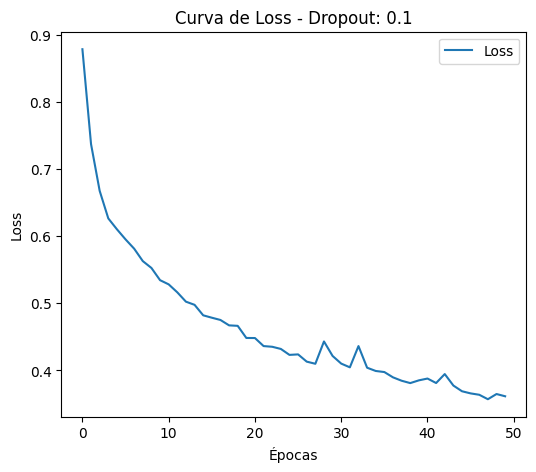

   Dropout  Final Loss  Explained Variance (PCA)
0      0.0    0.323979                       1.0
1      0.1    0.361588                       1.0


In [26]:
digits = load_digits()
X = digits.data
y = digits.target 

scaler = StandardScaler()
X = scaler.fit_transform(X)

input_dim = X.shape[1]
latent_dim = 2 

learning_rate = 0.001

dropouts = [0.0, 0.1]

results = []

for dropout_rate in dropouts:
    inputs = keras.Input(shape=(input_dim,))
    h = layers.Dense(256, activation="relu")(inputs)
    h = layers.Dropout(dropout_rate)(h)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dropout(dropout_rate)(h)
    h = layers.Dense(64, activation="relu")(h)
    h = layers.Dropout(dropout_rate)(h)
    z_mean = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    def sampling(args):
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

    class KLDivergenceLayer(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
            self.add_loss(kl_loss)
            return z_mean

    kl_layer = KLDivergenceLayer()([z_mean, z_log_var])
    encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

    latent_inputs = keras.Input(shape=(latent_dim,))
    h = layers.Dense(64, activation="relu")(latent_inputs)
    h = layers.Dense(128, activation="relu")(h)
    h = layers.Dense(256, activation="relu")(h)
    outputs = layers.Dense(input_dim, activation="linear")(h)
    decoder = keras.Model(latent_inputs, outputs, name="decoder")

    outputs = decoder(z)
    vae = keras.Model(inputs, outputs, name="vae")

    def reconstruction_loss_fn(x, x_reconstructed):
        return tf.reduce_mean(tf.keras.losses.mse(x, x_reconstructed))

    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=reconstruction_loss_fn)
    history = vae.fit(X, X, epochs=50, batch_size=32, verbose=0)

    z_mean, _, _ = encoder.predict(X)

    pca = PCA(n_components=2)
    z_pca = pca.fit_transform(z_mean)
    explained_variance = np.sum(pca.explained_variance_ratio_)

    plt.figure(figsize=(6, 5))
    plt.scatter(z_pca[:, 0], z_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6)
    plt.colorbar(label="Classes")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(f"Projeção do Espaço Latente (PCA) - Dropout: {dropout_rate}")
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(history.history["loss"], label="Loss")
    plt.xlabel("Épocas")
    plt.ylabel("Loss")
    plt.title(f"Curva de Loss - Dropout: {dropout_rate}")
    plt.legend()
    plt.show()

    results.append({
        "Dropout": dropout_rate,
        "Final Loss": history.history["loss"][-1],
        "Explained Variance (PCA)": explained_variance
    })

df_results = pd.DataFrame(results)
print(df_results)

1. PCA com Dropout 0.0

	•	Distribuição no espaço latente: O PCA apresenta um espalhamento dos dados, mas algumas classes ainda se sobrepõem, indicando que a separação dos dígitos não é totalmente clara.
	
	•	Agrupamento das classes: As classes formam agrupamentos relativamente bem definidos, mas há um certo nível de mistura entre algumas delas.
	
	•	Curva de loss: O loss decai de forma consistente ao longo das épocas, estabilizando em torno de 0.323979, o que sugere que o modelo foi capaz de reconstruir os dados de forma relativamente eficiente.
	
	•	Explicação: Sem dropout, a rede neural aprende de forma mais direta, o que pode resultar em um melhor ajuste aos dados de treino. No entanto, isso pode levar a overfitting, especialmente se os dados forem ruidosos.

2. PCA com Dropout 0.1
	
	•	Distribuição no espaço latente: A projeção no espaço latente mostra um comportamento mais alongado das classes, com algumas delas mais bem separadas, mas ainda com sobreposição.
	
	•	Agrupamento das classes: Algumas classes parecem estar melhor estruturadas, mas o efeito do dropout faz com que a variabilidade na distribuição aumente, tornando a separação entre os grupos um pouco mais difusa.
	
	•	Curva de loss: A loss final aumentou para 0.361588, o que indica que o modelo teve uma performance pior na reconstrução dos dados. Isso ocorre porque o dropout remove aleatoriamente neurônios durante o treinamento, reduzindo a capacidade de memorização da rede.
	
	•	Explicação: O uso do dropout (mesmo que baixo) adiciona regularização, o que ajuda a evitar overfitting, mas também pode prejudicar a capacidade de aprendizado da rede, especialmente em um problema onde a separação entre classes já não é perfeita.

	Comparação e Conclusões
	
	1.	O modelo com dropout 0.0 teve um desempenho melhor na reconstrução dos dados, apresentando um menor erro final e uma melhor separação das classes no espaço latente. Isso sugere que, para este caso, a regularização via dropout não foi benéfica.
	
	2.	O dropout 0.1 causou um leve aumento na perda e um espalhamento diferente no espaço latente, o que pode ser útil se quisermos melhorar a generalização do modelo para novos dados, mas aqui parece que reduziu a eficiência da reconstrução.
	
	3.	A separação entre classes ainda é um desafio, principalmente porque há uma sobreposição considerável nos espaços latentes gerados. Isso pode indicar que a arquitetura ou a dimensionalidade do espaço latente precisaria ser ajustada para melhorar a discriminação entre os dígitos.